# Python vs MATLAB: AR(1)-GARCH(1,1) bootstrap for Montecarlo VaR estimation of SP500 Index.

## 1. Preliminary remarks: the story so far ..
Back in 2011, when I was still an undergradate Economics student, R was the first statistical software I ever used. Now, to quote a dear friend, **"I would rather die hanging than using R for anything different than uninstalling it from my computer .."**.<br> I could go deeper on the matter, but I won't (ank in private if interested).
After that it came MATLAB. It was love at first sight. Easy, intuitive and most of all a great documentation makes the big difference. No packages needed, all in one place. I used it for years, no complaints. <br>
As you all know, all love stories are bound to end sooner or later as one of the two starts cheating. In this particular case, I was the traitor and it all started when I first heard about Python. <br>
I have to admit that the relationship with Python was not easy at first. But in the end it all worked out well.<br>
I will address in details the set up of Python, Anaconda, Pycharm, enviroments and packages in a different article.<br> <br>

Right now I will assume that you have everything set up and working and will skip directly to the main topic. I intentionally don't want to be matematically formal here to keep things as simple as possible. So I am going to skip every complicated proof and formulas in favour of intuition.<br>

## 2. The model in short
Volatility clustering is one of the main features of financial time series. In loose terms it means that we witness periods with higher volatility and periods with lower volatility. We want a model that takes into account this feature. One of the simplest models that adapts very well to **equity** financial time series is the $AR(1)\text{-}GRACH(1,1)$ model:

$$ r_t= \mu + \rho r_{t-1} +\epsilon_t  $$

$$ \epsilon_t = \sigma_tz_t \quad t_t \sim Student\text{-}t(\nu)$$

$$ \sigma_t^2=\omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $$<

The above three equations specify:
- a model for the conditional mean
- the error distribution
- a model for the conditional variance 

The set up I chose identifies the $AR(1)\text{-}GRACH(1,1)$ whit $Student\text{-}t(\nu)$ disturbances. <br>
Now let's see how we can implement this in Python.

## 3. Python implementation
### 3.1 Packages
First of all we need to import the packages we need for the job. In addition to the standard packages *numpy, scipy, pandas, matplotlib*, the main star of this article is the **arch package** that you can find __[here](https://anaconda.org/bashtage/arch)__ 

In [74]:
# IMPORTING REQUIRED PACKAGES 
import numpy as np
import pandas as pd
import scipy.stats as sps
from arch.univariate import ARX, StudentsT, GARCH
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### 3.2 Dataset
Now we import the dataset: **SP500 INDEX**, two years of daily prices(last data point 2018-07-19)<br>
Then main thing to poin out in this section (that hopefully will be clear to the more quantitative readers) is that we want to scale log returns for 100 in order to achieve convergence when whe use the gradient descent algorithm to maximize the likelihood (for additional details on this email me)

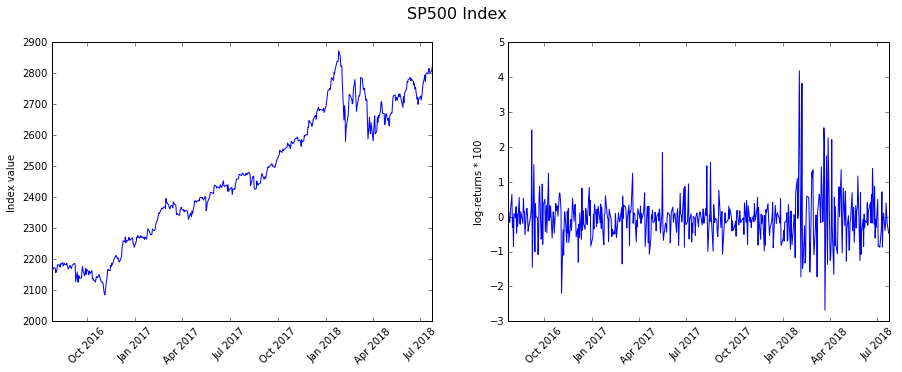

In [75]:
# DATA IMPORT 
t1 = pd.read_excel('SPX.xlsx')  # import data from excel
log_ret = 100 * (np.log(t1.iloc[1:, 1].values / t1.iloc[:-1, 1].values))  # calculating log returns

# PLOTTING 
plt.rcParams['figure.figsize'] = [15, 5]
plt1 = plt.subplot(1, 2, 1)
plt.plot(t1.iloc[:, 0].values, t1.iloc[:, 1].values)
plt.ylabel('Index value')
plt.setp(plt1.xaxis.get_majorticklabels(), rotation=45)
plt2 = plt.subplot(1, 2, 2)
plt.plot(t1.iloc[1:, 0].values, log_ret)  # plot showing non constant conditional variance
plt.ylabel('log-returns * 100')
plt.setp(plt2.xaxis.get_majorticklabels(), rotation=45)
plt.suptitle('SP500 Index', fontsize=16, y=1)
plt.show()

We can see that around the period we have a greater variability of the returns, accordingly with the volatility clustering discussed above. <br>
### 3.3 Model specification and parameter estimation
Following the three equations for conditional mean, distribution of errors and conditional variance we make use of the classes available in the arch package to construct our model:

In [76]:
# MODEL SPECIFICATION
mdl = ARX(log_ret, lags=1)  # model for the conditional mean
mdl.distribution = StudentsT()  # teorethical distribution of errors
mdl.volatility = GARCH(p=1, q=1)  # model for the conditional variance

We now turn to parameter estimation using the fit method of the ARX class. 
After the estimation we save the standardized residuals that will serve as invariants in the Motecarlo simulation that we are going to perform later on. Plesekeep in mind the time Python taks to complete the estimation (more o this later).

In [96]:
%%timeit
### PARAMETER ESTIMATION AND EXTRACTION OF STANDARDIZED RESIDUALS ###
mdl_est = mdl.fit(disp='off')# parameter estimation

24.8 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
std_res = (mdl_est.resid / mdl_est.conditional_volatility)[1:]  # standardized residuals. We discard the first obs of the conditional variace because is n.a.
print(mdl_est.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                            y   R-squared:                       0.007
Mean Model:                              AR   Adj. R-squared:                  0.005
Vol Model:                            GARCH   Log-Likelihood:               -400.471
Distribution:      Standardized Student's t   AIC:                           812.942
Method:                  Maximum Likelihood   BIC:                           838.254
                                              No. Observations:                  502
Date:                      Sun, Jul 29 2018   Df Residuals:                      496
Time:                              01:16:22   Df Model:                            6
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const  

### 3.4 Python vs MATLAB
I don't want to comment on the significance of the parameters, that's not the scope of this article.<br>
The main thing that I want to point out here is that these results are extremely similar to the one obtained with MATLAB except for the fact that Python is more than 50 times faster.<br>
Below I will give you the MATLAB code for reproducibility of what we have done so far, showing the results of the estimation.

In [ ]:
% MATLAB CODE
filename = '~\SPX.xlsx'; % file path and name
opts = detectImportOptions(filename); % import option fo readtable functions
t1 = readtable(filename, opts); % import dataset
log_ret = log(t1{2:end, 2}./t1{1:end-1, 2}); % calculating log-returns

mdl_var = garch('GARCHLags', 1, 'ARCHLags', 1); % model for the variance 
mdl_mean = arima('ARLags', 1, 'Distribution', struct('Name', 't', 'DoF', NaN), 'Variance', mdl_var); % model for the mean and specification of errors distribution 
opt = optimoptions(@fmincon, 'Display', 'off'); % option for the optimization function
tic
mdl_est = estimate(mdl_mean, log_ret, 'Options', opt); % parameters estimation
toc   

    ARIMA(1,0,0) Model:
    --------------------
    Conditional Probability Distribution: t

                                  Standard          t     
     Parameter       Value          Error       Statistic 
    -----------   -----------   ------------   -----------
     Constant   -0.000763642   0.000206979       -3.68946
        AR{1}      -0.109493     0.0500274       -2.18867
          DoF        4.48845       1.26719        3.54204
 
 
    GARCH(1,1) Conditional Variance Model:
    ----------------------------------------
    Conditional Probability Distribution: t

                                  Standard          t     
     Parameter       Value          Error       Statistic 
    -----------   -----------   ------------   -----------
     Constant    3.84198e-06   2.00901e-06        1.91237
     GARCH{1}       0.670439     0.0822285        8.15337
      ARCH{1}       0.262933     0.0781983        3.36239
          DoF        4.48845       1.26719        3.54204
Elapsed time is 2.031343 seconds.

You can see for yourself that Python took about .024 seconds on average vs 2 seconds for MATLAB in order to estimate 6 parameters for the $AR(1)-GRACH(1,1)$ model.

### 3.5 Montecarlo Simulation
Finally we are going to perform the 1 month ahead (20 days) simulation using 10000 scenarios.<br>
The distribution from which we extract the random numbers is the empirical distribution of the standardized residuals.<br>
This is a non-parametric technique, hence, in order to simulate, it's sufficent to extract 10000 random numbers from a discrete uniform distribution of the same length of the vector of standardized residuals (remember that Python is 0-indexed and instead 0 502 days of observations we have 501 because the vector of the conditional variances hase the first observation missing).

In [91]:
# PARAMETERS FOR MONTECARLO SIMULATION
n_step = 20  # how many days ahead
n_scen = 10000 # how many scenarios
prob = 5  # percentile for VaR estimation

# SCENARIOS
sim_unif = np.random.randint(std_res.shape[0], size=(n_scen, n_step))  # simulation from the discrete uniform
sim_std_res = std_res[sim_unif]  # simulation from standardized residuals
sim_log_ret = np.zeros(sim_std_res.shape)  # empty matrix to store simulated returns

# INITIAL VALUES FOR THE SIMULATION 
v_0 = (mdl_est.conditional_volatility[-1])**2  # conditional variance
e_0 = mdl_est.resid[-1]  # residual
r_0 = log_ret[-1]  # return
param = mdl_est._params[:-1] # AR-GARCH parameters

# ACTUAL SIMULATION
for i in range(n_scen):
    v_t = v_0
    e_t = e_0
    r_t = r_0
    for j in range(n_step):
        v_t = param[2] + param[4]*v_t + param[3]*e_t**2  # conditional variance
        e_t = (v_t**0.5)*sim_std_res[i, j] # innovation
        sim_log_ret[i, j] = param[0] + param[1]*r_t + e_t # simulated return
        r_t = sim_log_ret[i, j]

# ONE MONTH SCENARIOS AND VaR
sim_log_ret = sim_log_ret/100  # array containig the simulated daily returns
log_ret_m01 = np.sum(sim_log_ret, axis=1)  # array containing the one month scenarios for returns
sp500_sim = np.hstack((t1.iloc[-1, 1] * np.ones((n_scen, 1)),
                     t1.iloc[-1, 1] * np.ones((n_scen, 1)) * np.exp(np.cumsum(sim_log_ret, axis=1))))  # SP500 simulations
VaR5_m01 = np.percentile(log_ret_m01, prob)  # estimated VaR 5% 1 month

### 3.6 Normality YES, Normality NO
Finally, just to have some fun, we draw the histogram of the simulated 1 month returns vs the density of a generalized $Student\text{-}t$ and a $Normal$ disrtibution fitted over the same data.<br>
It is worth noting that the theoretical $Student\text{-}t$ distribution fits extremely well the 1 month log return of the SP500. Clearly the same cannot be said for the $Normal$ distribution.<br>

In [92]:
#FITTING DISTRIBUTIONS TO DATA
t_param = sps.t.fit(log_ret_m01)  # fitting a Student-t over the simulated 1 month returns
norm_param = sps.norm.fit(log_ret_m01)  # fitting a Normal over the simulated 1 month returns
x = np.linspace(-.15, .15, 1000)  # x data for plot
fx_t = sps.t.pdf(x, t_param[0], t_param[1], t_param[2])  # Student-t pdf
fx_norm = sps.norm.pdf(x, norm_param[0], norm_param[1])  # Normal pdf

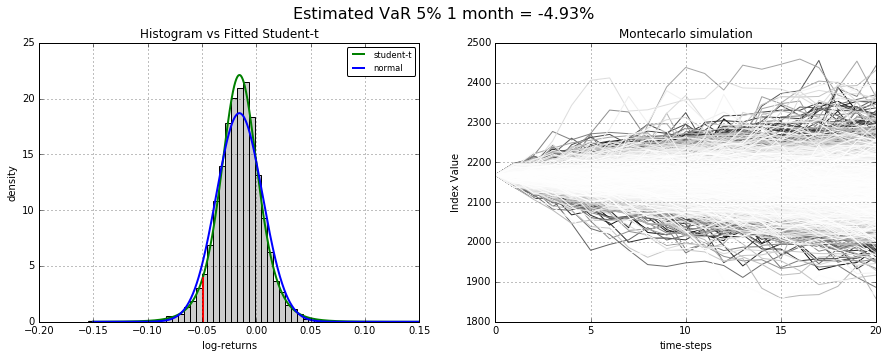

In [94]:
# PLOTTING 
plt.rcParams['figure.figsize'] = [15, 5]
plt3 = plt.subplot(1, 2, 1)
plt.title('Histogram vs Fitted Student-t')
plt.xlabel('log-returns')
plt.ylabel('density')
plt3.grid(True)
plt.hist(log_ret_m01, 50, normed=True, color=(.8, .8, .8))  # normalized histogram plot
plt.plot(x, fx_t, color='green', linewidth=2, label='student-t')
plt.plot(x, fx_norm, color='blue', linewidth=2, label='normal')
plt.axvline(x=VaR5_m01, color='red', linewidth=2, ymax=(sps.t.pdf(VaR5_m01, t_param[0], t_param[1], t_param[2]))/25)  # VaR line
plt.legend(fontsize='small', fancybox=True)
plt4 = plt.subplot(1, 2, 2)
plt4.grid(True)
plt.title('Montecarlo simulation')
plt.xlabel('time-steps')
plt.ylabel('Index Value')
plt.suptitle('Estimated VaR 5% 1 month = ' + "{0:.2%}".format(VaR5_m01), fontsize=16, y=1)
for rng in np.arange(0, sp500_sim.shape[0]):
    plt.plot(np.arange(0, 21), sp500_sim[rng, :],
             color=(rng/(sp500_sim.shape[0]), rng/(sp500_sim.shape[0]), rng/(sp500_sim.shape[0])))
plt.show()

In fact let's compare the VaRs calculated using:
- $AR(1)\text{-}GRACH(1,1)$ bootstrap Montecarlo
- theoretical $Student\text{-}t$ 
- theoretical $Normal$
- theoretical $Normal$ with square root rule

In [93]:
VaR_t = sps.t.ppf(prob/100, t_param[0], t_param[1], t_param[2])
VaR_norm = sps.norm.ppf(prob/100, norm_param[0], norm_param[1])
norm_param_sqrt = sps.norm.fit(log_ret/100)
VaR_norm_sqrt = sps.norm.ppf(prob/100, norm_param_sqrt[0], norm_param_sqrt[1]) * (n_step)**(0.5)

print('VaR 5% 1 month AR-GARCH = ' + "{0:.2%}".format(VaR5_m01))
print('VaR 5% 1 month Stundent-t = ' + "{0:.2%}".format(VaR_t))
print('VaR 5% 1 month Normal = ' + "{0:.2%}".format(VaR_norm))
print('VaR 5% 1 month Normal sqrt rule = ' + "{0:.2%}".format(VaR_norm_sqrt))

VaR 5% 1 month AR-GARCH = -4.93%
VaR 5% 1 month Stundent-t = -4.93%
VaR 5% 1 month Normal = -5.07%
VaR 5% 1 month Normal sqrt rule = -5.11%


We can see that in this particular time period the Normal distribution assumption led to an overestimation of the risk. This is not always true in general and if we run the same experiment for over a rolling window, we will see that the $AR(1)\text{-}GRACH(1,1)$ is much more responsive to changes in market conditions, therefore giving a better representation of the risk esposition. This aspect along with back testing procedures will be covered in another article.<br>
Though there is a lot more to say on the topic, a lot of experiments to run, a lot of data to analyze, but for this article I am going to stop here leving you with some final thoughts.

### Final remarks: the story so far ..
Careful readers should have something to take home by now:
- R can very well go to hell. Please uninstall it ASAP!
- Normality too.
- Sorry MATLAB but Python is the way to go.

Turning serious for a while, as it is right now, and having over 7 years of academic and working experience with several programming, scripting, markup languages and statistical softwares, I see no reason why, in 2018, one should even bother learning something else other than Python if you work in Quantitative Finance/Risk Management/Insurance sector.<br>
It is a all rounded scripting language that is  free solid, easy to learn, great documentation and can be integrated basically with everything: VBA, JS, MySQL, Windows OS and whatever you can think about.<br>
Please do yourself a favour and start learning it!<br>
That's all folks!
<br>
<br>
<br>

__[Giovambattista Perciaccante](https://www.linkedin.com/in/giovambattista-perciaccante-3104b8b1/)__ <br>
Actuary, Risk Manager <br>
__[Symphonia SGR](https://www.symphonia.it/)__<br>
Office +39 0110828681<br>
Mobile +39 3271073180<br>
email: giovambattista.perciaccante@symphonia.it<br>
email: giovambattista.perciaccante@carloalberto.org